In [1]:
import os
import glob
import pickle
import tensorflow as tf    # used for creating tensors out of the dataset and training the model
import tensorflow_hub as hub    # downloading and using pre-trained 0models
import numpy as np
import h5py   # to manipulate the dataset as it's in `.h5` format
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report   # essential for model's evaluation
from sklearn.metrics import f1_score
from tqdm import tqdm   # getting a progress bar for an iterable object
import random

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# Directory containing the original 'good' images
good_dir = "C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/train - Copy/good"

# Directory where augmented images will be saved
augmented_dir = "C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/train - Copy/good_augmented"

# Ensure the directory exists, create it if not
os.makedirs(augmented_dir, exist_ok=True)

# Data augmentation parameters
data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator instance for data augmentation
datagen = ImageDataGenerator(**data_gen_args)

# Generate augmented images and save them to the augmented directory
batch_size = 4  # Number of augmented images to generate per original image

# Iterate through each image in the 'good' directory
for img_file in os.listdir(good_dir):
    img_path = os.path.join(good_dir, img_file)
    img = tf.keras.preprocessing.image.load_img(img_path, color_mode="grayscale")
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)  # Add batch dimension

    # Generate augmented images
    i = 0
    for batch in datagen.flow(img_array, batch_size=batch_size, save_to_dir=augmented_dir, save_prefix='aug', save_format='jpeg'):
        i += 1
        if i >= batch_size:
            break  # Break the loop after generating desired number of augmented images per original image


In [3]:
test_dir = "C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/test - Copy"
train_dir = "C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/train - Copy"

In [4]:
# train and test data pipelines created to load and preprocess images from the train and test directories respectively
# The dataset is then prefetched and cached for optimized performance.
# the ratio of train and test data split is 3:1
# train - 1080000 images and test - 36000 images


# create train data pipeline
IMG_SIZE = (64, 64) # define image size
train_data = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                         image_size=IMG_SIZE,
                                                         color_mode="grayscale",
                                                         label_mode="int", #  label type is encoding of the form `[1, 2, 3, ...]`
                                                         batch_size=len(os.listdir("C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/train - Copy/good_augmented")) + len(os.listdir("C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/train - Copy/damaged")))
                                                        # Batch size is set to be the size of the whole dataset to make loading data into x_train, y_train easier.
class_names = train_data.class_names
print(f"The class_names are as follows: {class_names}")

train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE).\
                        cache()

# create test data pipeline
test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        image_size=IMG_SIZE,
                                                        color_mode="grayscale",
                                                        shuffle=False,
                                                        batch_size=len(os.listdir("C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/test - Copy/good")) + len(os.listdir("C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/test - Copy/damaged")),
                                                        label_mode="int")

test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE).\
                      cache()

Found 3578 files belonging to 3 classes.
The class_names are as follows: ['damaged', 'good', 'good_augmented']
Found 72 files belonging to 2 classes.


In [5]:
# check the proportions of classes
damaged_counts = 0
for _ in os.listdir(f"C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/train - Copy/damaged"):
  damaged_counts += 1

good_counts = 0
for _ in os.listdir(f"C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/train - Copy/good_augmented"):
  good_counts += 1

total = damaged_counts + good_counts

new_train_df64 = pd.Series({"damaged": damaged_counts/total,
                            "good": good_counts/total}).round(2)
new_train_df64

damaged    0.6
good       0.4
dtype: float64

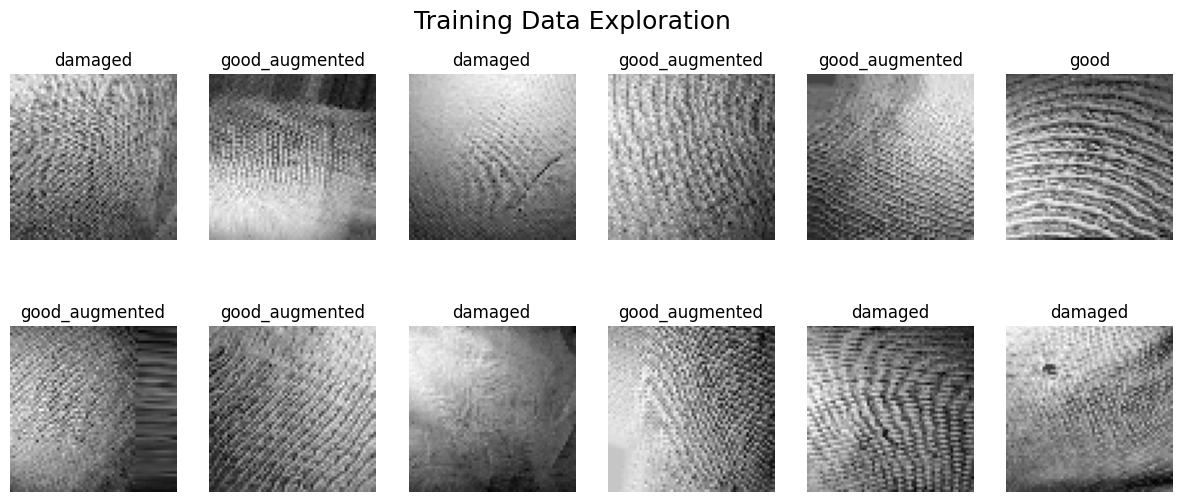

In [6]:
# explore the train data
def explore_data(n_rows, n_cols, figsize):
    count = 0
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize) # plot 20 figures
    fig.suptitle("Training Data Exploration", fontsize=18, y=0.95)
    for data, ax in zip(train_data.shuffle(10000).take(1).unbatch(), axs.ravel()):
        img, label = data

        ax.axis("off")
        ax.set_title(f"{class_names[label]}")
        ax.imshow(np.squeeze(img), cmap="gray")

        count+=1
        if count == n_rows*n_cols:
          break

explore_data(n_rows=2, n_cols=6, figsize=(15, 6))

In [7]:
# import the necessary packages
from imutils import paths
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
import random
from typing import Tuple

In [12]:
print(len(os.listdir("C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/train - Copy/good_augmented")))

print(len(os.listdir("C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/train - Copy/damaged")))

1301
1932


In [17]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import os
import random
from imutils import paths  # Ensure you have installed the imutils library


encoder_model = InceptionV3(include_top=True, weights='imagenet')



In [18]:
# Define the directories for train and test data
train_dir = "C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/train - Copy"
test_dir = "C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/test - Copy"


In [22]:
# Quantify image using the InceptionV3 model
def quantify_image(image, model=encoder_model):
    # Normalize and resize the image
    image = cv2.resize(image, (299, 299))

    # Ensure the image has the correct data type (float32) and range [0, 1]
    image = image.astype(np.float32) / 255.0

    # Add batch dimension
    image = np.expand_dims(image, axis=0)

    # Extract features using the model
    encoding = model.predict(image)

    return encoding.reshape((encoding.shape[0], -1))


# Load dataset
def load_dataset(datasetPath):
    imagePaths = list(paths.list_images(datasetPath))
    random.shuffle(imagePaths)  # shuffle to avoid bias
    data = []

    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        features = quantify_image(image)
        data.append(features)

    return np.array(data)


In [23]:
# Load train and test data
print("started train data loading")
train_data = load_dataset(train_dir)
print("done train data loading")
test_data = load_dataset(test_dir)
print("done test data loading")

started train data loading
1/1 [==============================] - 0s 207ms/step
done train data loading
1/1 [==============================] - 0s 197ms/step
done test data loading


In [37]:
# import the necessary packages
from imutils import paths
import numpy as np
import cv2
from tensorflow.keras.applications.inception_v3 import InceptionV3
import random
import os
import pickle
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load InceptionV3 model
encoder_model = InceptionV3(include_top=True, weights='imagenet')

# Function to quantify image using InceptionV3 model
def quantify_image(image, model=encoder_model):
    image_resized = cv2.resize(image, (299, 299))
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    image_np = np.expand_dims(image_rgb, axis=0)
    encoding = model.predict(image_np)
    return encoding.flatten()

# Function to load dataset
def load_dataset(datasetPath):
    imagePaths = list(paths.list_images(datasetPath))
    random.shuffle(imagePaths)
    data = []
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        features = quantify_image(image)
        data.append(features)
    return np.array(data)

# Define dataset directories
train_good_dir = "C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/train - Copy/good_augmented"
train_damaged_dir = "C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/train - Copy/damaged"
test_good_dir = "C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/test - Copy/good"
test_damaged_dir = "C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/test - Copy/damaged"

# Load train and test data
print("[INFO] Loading train data...")
train_good_data = load_dataset(train_good_dir)
train_damaged_data = load_dataset(train_damaged_dir)
X_train = np.vstack((train_good_data, train_damaged_data))
y_train = np.hstack((np.zeros(len(train_good_data)), np.ones(len(train_damaged_data))))

print("[INFO] Loading test data...")
test_good_data = load_dataset(test_good_dir)
test_damaged_data = load_dataset(test_damaged_dir)
X_test = np.vstack((test_good_data, test_damaged_data))
y_test = np.hstack((np.zeros(len(test_good_data)), np.ones(len(test_damaged_data))))

# Train the Isolation Forest model
print("[INFO] Training the Isolation Forest model...")
isolation_model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
isolation_model.fit(X_train)

# Make predictions
print("[INFO] Making predictions...")
y_pred_train = isolation_model.predict(X_train)
y_pred_test = isolation_model.predict(X_test)

# Convert predictions to binary (1 for anomalies, -1 for normal instances)
y_pred_train_binary = np.where(y_pred_train == 1, -1, 1)
y_pred_test_binary = np.where(y_pred_test == 1, -1, 1)



[INFO] Loading train data...
1/1 [==============================] - 1s 750ms/step
[INFO] Loading test data...
1/1 [==============================] - 1s 736ms/step
[INFO] Training the Isolation Forest model...
[INFO] Making predictions...


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [39]:
# Calculate metrics
accuracy_train = accuracy_score(y_train, y_pred_train_binary)
precision_train = precision_score(y_train, y_pred_train_binary,average='weighted')
recall_train = recall_score(y_train, y_pred_train_binary,average='weighted')
f1_train = f1_score(y_train, y_pred_train_binary,average='weighted')

accuracy_test = accuracy_score(y_test, y_pred_test_binary)
precision_test = precision_score(y_test, y_pred_test_binary,average='weighted')
recall_test = recall_score(y_test, y_pred_test_binary,average='weighted')
f1_test = f1_score(y_test, y_pred_test_binary,average='weighted')

# Print metrics
print("Train Set Metrics:")
print(f"Accuracy: {accuracy_train}")
print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1 Score: {f1_train}")

print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")


Train Set Metrics:
Accuracy: 0.07856480049489638
Precision: 0.46847899554364136
Recall: 0.07856480049489638
F1 Score: 0.13456311574125868

Test Set Metrics:
Accuracy: 0.1111111111111111
Precision: 0.8333333333333334
Recall: 0.1111111111111111
F1 Score: 0.19607843137254902


c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

1/1 [==============================] - 1s 1s/step


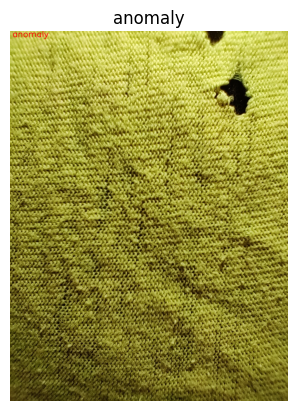

In [45]:
# import the necessary packages
import cv2
import os
import matplotlib.pyplot as plt

# Define the directory for test data
test_dir = "own_dataset/test - Copy"

# Load a random image from the test data (either from "good" or "damaged" folder)
category = "good" if random.random() < 0.5 else "damaged"
image_files = os.listdir(os.path.join(test_dir, category))
random_image_file = random.choice(image_files)
image_path = os.path.join(test_dir, category, random_image_file)
image = cv2.imread(image_path)

# Quantify the image using the InceptionV3 model
image_features = quantify_image(image)

# Use the trained Isolation Forest model to predict anomalies
pred = isolation_model.predict([image_features])[0]
label = "anomaly" if pred == -1 else "good"
color = (0, 0, 255) if pred == -1 else (0, 255, 0)

# Draw the predicted label text on the image
cv2.putText(image, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 2)

# Display the image with the predicted label
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(label)
plt.axis("off")
plt.show()


In [46]:
from sklearn.covariance import EllipticEnvelope



# Train the Elliptic Envelope model
print("[INFO] Training the Elliptic Envelope model...")
elliptic_model = EllipticEnvelope(contamination=0.1)
elliptic_model.fit(X_train)

# Make predictions
print("[INFO] Making predictions...")
y_pred_train = elliptic_model.predict(X_train)
y_pred_test = elliptic_model.predict(X_test)

# Convert predictions to binary (1 for anomalies, -1 for normal instances)
y_pred_train_binary = np.where(y_pred_train == 1, -1, 1)
y_pred_test_binary = np.where(y_pred_test == 1, -1, 1)

# Calculate metrics
accuracy_train = accuracy_score(y_train, y_pred_train_binary)
precision_train = precision_score(y_train, y_pred_train_binary, average='weighted')
recall_train = recall_score(y_train, y_pred_train_binary, average='weighted')
f1_train = f1_score(y_train, y_pred_train_binary, average='weighted')

accuracy_test = accuracy_score(y_test, y_pred_test_binary)
precision_test = precision_score(y_test, y_pred_test_binary, average='weighted')
recall_test = recall_score(y_test, y_pred_test_binary, average='weighted')
f1_test = f1_score(y_test, y_pred_test_binary, average='weighted')

# Print metrics
print("Train Set Metrics:")
print(f"Accuracy: {accuracy_train}")
print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1 Score: {f1_train}")

print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")

[INFO] Training the Elliptic Envelope model...


c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\covariance\_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\covariance\_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-111261.912148783419980 > -112635.864007234224118). You may want to try with a higher value of support_fraction (current value: 0.656).
  warnings.warn(
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\covariance\_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-126217.624808824388310 > -130939.065251368927420). You may want to try with a higher value of support_fraction (current value: 0.656).
  warnings.warn(
c:\Users\Ananya Doshi\AppD

[INFO] Making predictions...
Train Set Metrics:
Accuracy: 0.1116609959789669
Precision: 0.4305968946733814
Recall: 0.1116609959789669
F1 Score: 0.17733583578410528

Test Set Metrics:
Accuracy: 0.09722222222222222
Precision: 0.8333333333333334
Recall: 0.09722222222222222
F1 Score: 0.17412935323383083


c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

1/1 [==============================] - 2s 2s/step


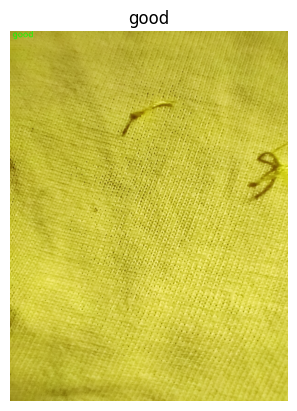

In [47]:
# import the necessary packages
import cv2
import os
import matplotlib.pyplot as plt

# Define the directory for test data
test_dir = "own_dataset/test - Copy"

# Load a random image from the test data (either from "good" or "damaged" folder)
category = "good" if random.random() < 0.5 else "damaged"
image_files = os.listdir(os.path.join(test_dir, category))
random_image_file = random.choice(image_files)
image_path = os.path.join(test_dir, category, random_image_file)
image = cv2.imread(image_path)

# Quantify the image using the InceptionV3 model
image_features = quantify_image(image)

# Use the trained Isolation Forest model to predict anomalies
pred = elliptic_model.predict([image_features])[0]
label = "anomaly" if pred == -1 else "good"
color = (0, 0, 255) if pred == -1 else (0, 255, 0)

# Draw the predicted label text on the image
cv2.putText(image, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 2)

# Display the image with the predicted label
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(label)
plt.axis("off")
plt.show()

In [59]:
from sklearn.neighbors import LocalOutlierFactor


# Train the LOF model
print("[INFO] Training the Local Outlier Factor (LOF) model...")
lof_model = LocalOutlierFactor(n_neighbors=10, contamination=0.1, novelty=False)
y_pred_train = lof_model.fit_predict(X_train)
y_pred_test = lof_model.fit_predict(X_test)

# Convert predictions to binary (1 for anomalies, -1 for normal instances)
y_pred_train_binary = np.where(y_pred_train == -1, 1, -1)
y_pred_test_binary = np.where(y_pred_test == -1, 1, -1)

# Calculate metrics
accuracy_train = accuracy_score(y_train, y_pred_train_binary)
precision_train = precision_score(y_train, y_pred_train_binary, average='weighted')
recall_train = recall_score(y_train, y_pred_train_binary, average='weighted')
f1_train = f1_score(y_train, y_pred_train_binary, average='weighted')

accuracy_test = accuracy_score(y_test, y_pred_test_binary)
precision_test = precision_score(y_test, y_pred_test_binary, average='weighted')
recall_test = recall_score(y_test, y_pred_test_binary, average='weighted')
f1_test = f1_score(y_test, y_pred_test_binary, average='weighted')

# Print metrics
print("Train Set Metrics:")
print(f"Accuracy: {accuracy_train}")
print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1 Score: {f1_train}")

print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")

[INFO] Training the Local Outlier Factor (LOF) model...
Train Set Metrics:
Accuracy: 0.06804825239715434
Precision: 0.4057692087385871
Recall: 0.06804825239715434
F1 Score: 0.11655073016959414

Test Set Metrics:
Accuracy: 0.1111111111111111
Precision: 0.8333333333333334
Recall: 0.1111111111111111
F1 Score: 0.19607843137254902


c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

In [60]:
# import the necessary packages
import cv2
import os
import matplotlib.pyplot as plt

# Define the directory for test data
test_dir = "own_dataset/test - Copy"

# Load a random image from the test data
category = "good" if random.random() < 0.5 else "damaged"
image_files = os.listdir(os.path.join(test_dir, category))
random_image_file = random.choice(image_files)
image_path = os.path.join(test_dir, category, random_image_file)
image = cv2.imread(image_path)

# Quantify the image using the InceptionV3 model
image_features = quantify_image(image)

# Use the trained LOF model to predict anomalies
pred = lof_model.fit_predict([image_features])[0]
# Use the trained LOF model to predict anomalies
# pred = lof_model.fit_predict([image_features], n_neighbors=1)[0]
label = "anomaly" if pred == -1 else "good"
color = (0, 0, 255) if pred == -1 else (0, 255, 0)

# Draw the predicted label text on the image
cv2.putText(image, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 2)

# Display the image with the predicted label
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(label)
plt.axis("off")
plt.show()

1/1 [==============================] - 1s 1s/step


c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (10) is greater than the total number of samples (1). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


ValueError: Expected n_neighbors <= n_samples,  but n_samples = 1, n_neighbors = 2

In [62]:
from sklearn.svm import OneClassSVM

# Train the One-Class SVM model
print("[INFO] Training the One-Class SVM model...")
svm_model = OneClassSVM(nu=0.1)
svm_model.fit(X_train)

# Make predictions
print("[INFO] Making predictions...")
y_pred_train = svm_model.predict(X_train)
y_pred_test = svm_model.predict(X_test)

# Convert predictions to binary (1 for anomalies, -1 for normal instances)
y_pred_train_binary = np.where(y_pred_train == 1, -1, 1)
y_pred_test_binary = np.where(y_pred_test == 1, -1, 1)

# Calculate metrics
accuracy_train = accuracy_score(y_train, y_pred_train_binary)
precision_train = precision_score(y_train, y_pred_train_binary, average='weighted')
recall_train = recall_score(y_train, y_pred_train_binary, average='weighted')
f1_train = f1_score(y_train, y_pred_train_binary, average='weighted')

accuracy_test = accuracy_score(y_test, y_pred_test_binary)
precision_test = precision_score(y_test, y_pred_test_binary, average='weighted')
recall_test = recall_score(y_test, y_pred_test_binary, average='weighted')
f1_test = f1_score(y_test, y_pred_test_binary, average='weighted')

# Print metrics
print("Train Set Metrics:")
print(f"Accuracy: {accuracy_train}")
print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1 Score: {f1_train}")

print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")


[INFO] Training the One-Class SVM model...
[INFO] Making predictions...
Train Set Metrics:
Accuracy: 0.2363130219610269
Precision: 0.3029573712201088
Recall: 0.2363130219610269
F1 Score: 0.26551716105187784

Test Set Metrics:
Accuracy: 0.5416666666666666
Precision: 0.7738095238095238
Recall: 0.5416666666666666
F1 Score: 0.6372549019607843


c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

1/1 [==============================] - 1s 1s/step


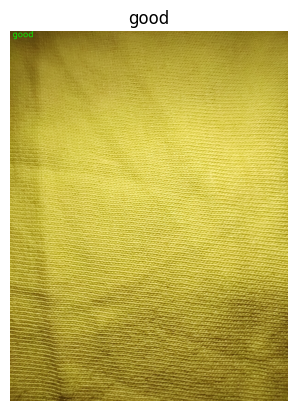

In [63]:
# Load a random image from the test data
category = "good" if random.random() < 0.5 else "damaged"
image_files = os.listdir(os.path.join(test_dir, category))
random_image_file = random.choice(image_files)
image_path = os.path.join(test_dir, category, random_image_file)
image = cv2.imread(image_path)

# Quantify the image using the InceptionV3 model
image_features = quantify_image(image)

# Use the trained One-Class SVM model to predict anomalies
pred = svm_model.predict([image_features])[0]
label = "anomaly" if pred == -1 else "good"
color = (0, 0, 255) if pred == -1 else (0, 255, 0)

# Draw the predicted label text on the image
cv2.putText(image, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 2)

# Display the image with the predicted label
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(label)
plt.axis("off")
plt.show()

In [64]:
from sklearn.linear_model import SGDOneClassSVM

# Train the SGD One-Class SVM model
print("[INFO] Training the SGD One-Class SVM model...")
sgd_ocsvm_model = SGDOneClassSVM(nu=0.1)
sgd_ocsvm_model.fit(X_train)

# Make predictions
print("[INFO] Making predictions...")
y_pred_train = sgd_ocsvm_model.predict(X_train)
y_pred_test = sgd_ocsvm_model.predict(X_test)

# Convert predictions to binary (1 for anomalies, -1 for normal instances)
y_pred_train_binary = np.where(y_pred_train == 1, -1, 1)
y_pred_test_binary = np.where(y_pred_test == 1, -1, 1)

# Calculate metrics
accuracy_train = accuracy_score(y_train, y_pred_train_binary)
precision_train = precision_score(y_train, y_pred_train_binary, average='weighted')
recall_train = recall_score(y_train, y_pred_train_binary, average='weighted')
f1_train = f1_score(y_train, y_pred_train_binary, average='weighted')

accuracy_test = accuracy_score(y_test, y_pred_test_binary)
precision_test = precision_score(y_test, y_pred_test_binary, average='weighted')
recall_test = recall_score(y_test, y_pred_test_binary, average='weighted')
f1_test = f1_score(y_test, y_pred_test_binary, average='weighted')

# Print metrics
print("Train Set Metrics:")
print(f"Accuracy: {accuracy_train}")
print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1 Score: {f1_train}")

print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")


[INFO] Training the SGD One-Class SVM model...
[INFO] Making predictions...
Train Set Metrics:
Accuracy: 0.022888957624497372
Precision: 0.4171836427408388
Recall: 0.022888957624497372
F1 Score: 0.04339692456381641

Test Set Metrics:
Accuracy: 0.06944444444444445
Precision: 0.8333333333333334
Recall: 0.06944444444444445
F1 Score: 0.12820512820512822


c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

1/1 [==============================] - 1s 1s/step


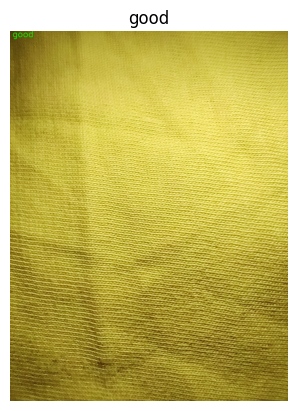

In [65]:
# Load a random image from the test data
category = "good" if random.random() < 0.5 else "damaged"
image_files = os.listdir(os.path.join(test_dir, category))
random_image_file = random.choice(image_files)
image_path = os.path.join(test_dir, category, random_image_file)
image = cv2.imread(image_path)

# Quantify the image using the InceptionV3 model
image_features = quantify_image(image)

# Use the trained SGD One-Class SVM model to predict anomalies
pred = sgd_ocsvm_model.predict([image_features])[0]
label = "anomaly" if pred == -1 else "good"
color = (0, 0, 255) if pred == -1 else (0, 255, 0)

# Draw the predicted label text on the image
cv2.putText(image, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 2)

# Display the image with the predicted label
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(label)
plt.axis("off")
plt.show()

In [68]:
from tensorflow.keras.applications import ResNet50

# Load ResNet50 model
encoder_model_resnet50 = ResNet50(include_top=True, weights='imagenet')

# Function to quantify image using ResNet50 model
def quantify_image_resnet50(image, model=encoder_model_resnet50):
    image_resized = cv2.resize(image, (224, 224))
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    image_np = np.expand_dims(image_rgb, axis=0)
    encoding = model.predict(image_np)
    return encoding.flatten()

def load_dataset_resnet50(datasetPath):
    imagePaths = list(paths.list_images(datasetPath))
    random.shuffle(imagePaths)
    data = []
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        features = quantify_image_resnet50(image)
        data.append(features)
    return np.array(data)

# Load train and test data
print("[INFO] Loading train data...")
train_good_data = load_dataset_resnet50(train_good_dir)
train_damaged_data = load_dataset_resnet50(train_damaged_dir)
X_train = np.vstack((train_good_data, train_damaged_data))
y_train = np.hstack((np.zeros(len(train_good_data)), np.ones(len(train_damaged_data))))

print("[INFO] Loading test data...")
test_good_data = load_dataset_resnet50(test_good_dir)
test_damaged_data = load_dataset_resnet50(test_damaged_dir)
X_test = np.vstack((test_good_data, test_damaged_data))
y_test = np.hstack((np.zeros(len(test_good_data)), np.ones(len(test_damaged_data))))

[INFO] Loading train data...
1/1 [==============================] - 3s 3s/step
[INFO] Loading test data...
1/1 [==============================] - 3s 3s/step


In [69]:
# Train the Isolation Forest model
print("[INFO] Training the Isolation Forest model...")
isolation_model_resnet = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
isolation_model_resnet.fit(X_train)

# Make predictions
print("[INFO] Making predictions...")
y_pred_train = isolation_model_resnet.predict(X_train)
y_pred_test = isolation_model_resnet.predict(X_test)

# Convert predictions to binary (1 for anomalies, -1 for normal instances)
y_pred_train_binary = np.where(y_pred_train == 1, -1, 1)
y_pred_test_binary = np.where(y_pred_test == 1, -1, 1)

# Calculate metrics
accuracy_train = accuracy_score(y_train, y_pred_train_binary)
precision_train = precision_score(y_train, y_pred_train_binary, average='weighted')
recall_train = recall_score(y_train, y_pred_train_binary, average='weighted')
f1_train = f1_score(y_train, y_pred_train_binary, average='weighted')

accuracy_test = accuracy_score(y_test, y_pred_test_binary)
precision_test = precision_score(y_test, y_pred_test_binary, average='weighted')
recall_test = recall_score(y_test, y_pred_test_binary, average='weighted')
f1_test = f1_score(y_test, y_pred_test_binary, average='weighted')

# Print metrics
print("Train Set Metrics:")
print(f"Accuracy: {accuracy_train}")
print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1 Score: {f1_train}")

print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")

[INFO] Training the Isolation Forest model...
[INFO] Making predictions...
Train Set Metrics:
Accuracy: 0.0838230745437674
Precision: 0.4998338889461686
Recall: 0.0838230745437674
F1 Score: 0.14356930852709096

Test Set Metrics:
Accuracy: 0.2777777777777778
Precision: 0.7936507936507936
Recall: 0.2777777777777778
F1 Score: 0.411522633744856


c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

1/1 [==============================] - 6s 6s/step


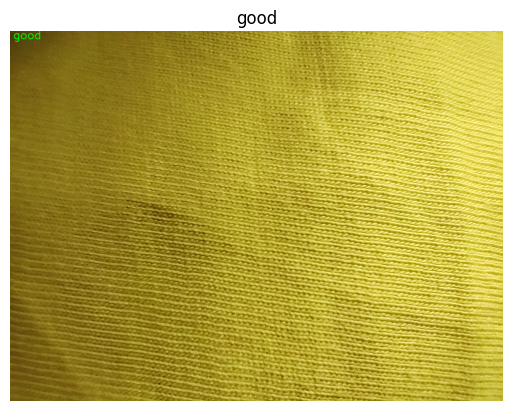

In [71]:

# Load a random image from the test data
category = "good" if random.random() < 0.5 else "damaged"
image_files = os.listdir(os.path.join(test_dir, category))
random_image_file = random.choice(image_files)
image_path = os.path.join(test_dir, category, random_image_file)
image = cv2.imread(image_path)

# Quantify the image using the ResNet model
image_features_resnet = quantify_image_resnet50(image)

# Use the trained Isolation Forest model to predict anomalies
pred_resnet = isolation_model_resnet.predict([image_features_resnet])[0]
label_resnet = "anomaly" if pred_resnet == -1 else "good"
color_resnet = (0, 0, 255) if pred_resnet == -1 else (0, 255, 0)

# Draw the predicted label text on the image
cv2.putText(image, label_resnet, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color_resnet, 2)

# Display the image with the predicted label
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(label_resnet)
plt.axis("off")
plt.show()

In [72]:
from sklearn.covariance import EllipticEnvelope

# Train the Elliptic Envelope model
print("[INFO] Training the Elliptic Envelope model...")
elliptic_model_resnet = EllipticEnvelope(contamination=0.1)
elliptic_model_resnet.fit(X_train)

# Make predictions
print("[INFO] Making predictions...")
y_pred_train = elliptic_model_resnet.predict(X_train)
y_pred_test = elliptic_model_resnet.predict(X_test)

# Convert predictions to binary (1 for anomalies, -1 for normal instances)
y_pred_train_binary = np.where(y_pred_train == 1, -1, 1)
y_pred_test_binary = np.where(y_pred_test == 1, -1, 1)

# Calculate metrics
accuracy_train = accuracy_score(y_train, y_pred_train_binary)
precision_train = precision_score(y_train, y_pred_train_binary, average='weighted')
recall_train = recall_score(y_train, y_pred_train_binary, average='weighted')
f1_train = f1_score(y_train, y_pred_train_binary, average='weighted')

accuracy_test = accuracy_score(y_test, y_pred_test_binary)
precision_test = precision_score(y_test, y_pred_test_binary, average='weighted')
recall_test = recall_score(y_test, y_pred_test_binary, average='weighted')
f1_test = f1_score(y_test, y_pred_test_binary, average='weighted')

# Print metrics
print("Train Set Metrics:")
print(f"Accuracy: {accuracy_train}")
print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1 Score: {f1_train}")

print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")


[INFO] Training the Elliptic Envelope model...


c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\covariance\_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\covariance\_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-43335.395566456776578 > -43340.043419540466857). You may want to try with a higher value of support_fraction (current value: 0.656).
  warnings.warn(
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\covariance\_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-43430.774231379728008 > -43443.618226253012836). You may want to try with a higher value of support_fraction (current value: 0.656).
  warnings.warn(
c:\Users\Ananya Doshi\AppData\

[INFO] Making predictions...
Train Set Metrics:
Accuracy: 0.09433962264150944
Precision: 0.5625436757512229
Recall: 0.09433962264150944
F1 Score: 0.1615816940987555

Test Set Metrics:
Accuracy: 0.3472222222222222
Precision: 0.8333333333333334
Recall: 0.3472222222222222
F1 Score: 0.4901960784313726


c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

1/1 [==============================] - 5s 5s/step


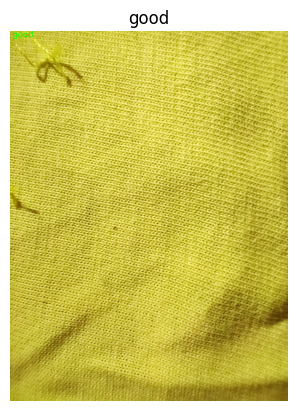

In [73]:
# Load a random image from the test data
category = "good" if random.random() < 0.5 else "damaged"
image_files = os.listdir(os.path.join(test_dir, category))
random_image_file = random.choice(image_files)
image_path = os.path.join(test_dir, category, random_image_file)
image = cv2.imread(image_path)

# Quantify the image using the ResNet model
image_features_resnet = quantify_image_resnet50(image)

# Use the trained Isolation Forest model to predict anomalies
pred_resnet = elliptic_model_resnet.predict([image_features_resnet])[0]
label_resnet = "anomaly" if pred_resnet == -1 else "good"
color_resnet = (0, 0, 255) if pred_resnet == -1 else (0, 255, 0)

# Draw the predicted label text on the image
cv2.putText(image, label_resnet, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color_resnet, 2)

# Display the image with the predicted label
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(label_resnet)
plt.axis("off")
plt.show()

In [74]:
from sklearn.neighbors import LocalOutlierFactor

# Train the LOF model
print("[INFO] Training the Local Outlier Factor (LOF) model...")
lof_model_resnet = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred_train = lof_model_resnet.fit_predict(X_train)
y_pred_test = lof_model_resnet.fit_predict(X_test)

# Convert predictions to binary (1 for anomalies, -1 for normal instances)
y_pred_train_binary = np.where(y_pred_train == -1, 1, -1)
y_pred_test_binary = np.where(y_pred_test == -1, 1, -1)

# Calculate metrics
accuracy_train = accuracy_score(y_train, y_pred_train_binary)
precision_train = precision_score(y_train, y_pred_train_binary, average='weighted')
recall_train = recall_score(y_train, y_pred_train_binary, average='weighted')
f1_train = f1_score(y_train, y_pred_train_binary, average='weighted')

accuracy_test = accuracy_score(y_test, y_pred_test_binary)
precision_test = precision_score(y_test, y_pred_test_binary, average='weighted')
recall_test = recall_score(y_test, y_pred_test_binary, average='weighted')
f1_test = f1_score(y_test, y_pred_test_binary, average='weighted')

# Print metrics
print("Train Set Metrics:")
print(f"Accuracy: {accuracy_train}")
print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1 Score: {f1_train}")

print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")


[INFO] Training the Local Outlier Factor (LOF) model...
Train Set Metrics:
Accuracy: 0.060315496442932263
Precision: 0.35965907138192943
Recall: 0.060315496442932263
F1 Score: 0.10330632901395845

Test Set Metrics:
Accuracy: 0.1111111111111111
Precision: 0.8333333333333334
Recall: 0.1111111111111111
F1 Score: 0.19607843137254902


c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

In [75]:
# Load a random image from the test data
category = "good" if random.random() < 0.5 else "damaged"
image_files = os.listdir(os.path.join(test_dir, category))
random_image_file = random.choice(image_files)
image_path = os.path.join(test_dir, category, random_image_file)
image = cv2.imread(image_path)

# Quantify the image using the ResNet model
image_features_resnet = quantify_image_resnet50(image)

# Use the trained Isolation Forest model to predict anomalies
pred_resnet = lof_model_resnet.predict([image_features_resnet])[0]
label_resnet = "anomaly" if pred_resnet == -1 else "good"
color_resnet = (0, 0, 255) if pred_resnet == -1 else (0, 255, 0)

# Draw the predicted label text on the image
cv2.putText(image, label_resnet, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color_resnet, 2)

# Display the image with the predicted label
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(label_resnet)
plt.axis("off")
plt.show()

1/1 [==============================] - 5s 5s/step


AttributeError: predict is not available when novelty=False, use fit_predict if you want to predict on training data. Use novelty=True if you want to use LOF for novelty detection and predict on new unseen data.

In [76]:
from sklearn.svm import OneClassSVM

# Train the One-Class SVM model
print("[INFO] Training the One-Class SVM model...")
svm_model_resnet = OneClassSVM(kernel='rbf', nu=0.1)
svm_model_resnet.fit(X_train)

# Make predictions
print("[INFO] Making predictions...")
y_pred_train = svm_model_resnet.predict(X_train)
y_pred_test = svm_model_resnet.predict(X_test)

# Convert predictions to binary (1 for anomalies, -1 for normal instances)
y_pred_train_binary = np.where(y_pred_train == 1, -1, 1)
y_pred_test_binary = np.where(y_pred_test == 1, -1, 1)

# Calculate metrics
accuracy_train = accuracy_score(y_train, y_pred_train_binary)
precision_train = precision_score(y_train, y_pred_train_binary, average='weighted')
recall_train = recall_score(y_train, y_pred_train_binary, average='weighted')
f1_train = f1_score(y_train, y_pred_train_binary, average='weighted')

accuracy_test = accuracy_score(y_test, y_pred_test_binary)
precision_test = precision_score(y_test, y_pred_test_binary, average='weighted')
recall_test = recall_score(y_test, y_pred_test_binary, average='weighted')
f1_test = f1_score(y_test, y_pred_test_binary, average='weighted')

# Print metrics
print("Train Set Metrics:")
print(f"Accuracy: {accuracy_train}")
print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1 Score: {f1_train}")

print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")


[INFO] Training the One-Class SVM model...
[INFO] Making predictions...
Train Set Metrics:
Accuracy: 0.060006186204763376
Precision: 0.3578146658876631
Recall: 0.060006186204763376
F1 Score: 0.10277655296773301

Test Set Metrics:
Accuracy: 0.027777777777777776
Precision: 0.8333333333333334
Recall: 0.027777777777777776
F1 Score: 0.053763440860215055


c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

1/1 [==============================] - 4s 4s/step


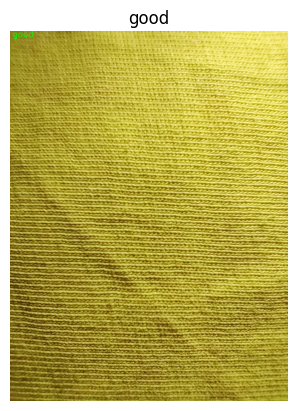

In [77]:
# Load a random image from the test data
category = "good" if random.random() < 0.5 else "damaged"
image_files = os.listdir(os.path.join(test_dir, category))
random_image_file = random.choice(image_files)
image_path = os.path.join(test_dir, category, random_image_file)
image = cv2.imread(image_path)

# Quantify the image using the ResNet model
image_features_resnet = quantify_image_resnet50(image)

# Use the trained Isolation Forest model to predict anomalies
pred_resnet = svm_model_resnet.predict([image_features_resnet])[0]
label_resnet = "anomaly" if pred_resnet == -1 else "good"
color_resnet = (0, 0, 255) if pred_resnet == -1 else (0, 255, 0)

# Draw the predicted label text on the image
cv2.putText(image, label_resnet, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color_resnet, 2)

# Display the image with the predicted label
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(label_resnet)
plt.axis("off")
plt.show()

In [78]:
from sklearn.linear_model import SGDOneClassSVM

# Train the SGD One-Class SVM model
print("[INFO] Training the SGD One-Class SVM model...")
sgd_svm_model_resnet = SGDOneClassSVM(nu=0.1)
sgd_svm_model_resnet.fit(X_train)

# Make predictions
print("[INFO] Making predictions...")
y_pred_train = sgd_svm_model_resnet.predict(X_train)
y_pred_test = sgd_svm_model_resnet.predict(X_test)

# Convert predictions to binary (1 for anomalies, -1 for normal instances)
y_pred_train_binary = np.where(y_pred_train == 1, -1, 1)
y_pred_test_binary = np.where(y_pred_test == 1, -1, 1)

# Calculate metrics
accuracy_train = accuracy_score(y_train, y_pred_train_binary)
precision_train = precision_score(y_train, y_pred_train_binary, average='weighted')
recall_train = recall_score(y_train, y_pred_train_binary, average='weighted')
f1_train = f1_score(y_train, y_pred_train_binary, average='weighted')

accuracy_test = accuracy_score(y_test, y_pred_test_binary)
precision_test = precision_score(y_test, y_pred_test_binary, average='weighted')
recall_test = recall_score(y_test, y_pred_test_binary, average='weighted')
f1_test = f1_score(y_test, y_pred_test_binary, average='weighted')

# Print metrics
print("Train Set Metrics:")
print(f"Accuracy: {accuracy_train}")
print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1 Score: {f1_train}")

print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")


[INFO] Training the SGD One-Class SVM model...
[INFO] Making predictions...
Train Set Metrics:
Accuracy: 0.06124342715743891
Precision: 0.48893512920732224
Recall: 0.06124342715743891
F1 Score: 0.108852163080195

Test Set Metrics:
Accuracy: 0.25
Precision: 0.8333333333333334
Recall: 0.25
F1 Score: 0.3846153846153846


c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

1/1 [==============================] - 4s 4s/step


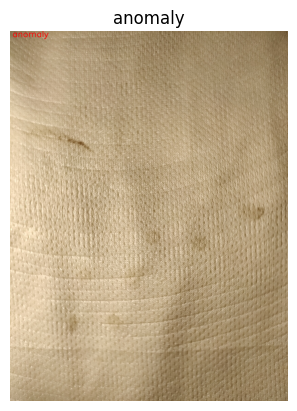

In [79]:
# Load a random image from the test data
category = "good" if random.random() < 0.5 else "damaged"
image_files = os.listdir(os.path.join(test_dir, category))
random_image_file = random.choice(image_files)
image_path = os.path.join(test_dir, category, random_image_file)
image = cv2.imread(image_path)

# Quantify the image using the ResNet model
image_features_resnet = quantify_image_resnet50(image)

# Use the trained Isolation Forest model to predict anomalies
pred_resnet = sgd_svm_model_resnet.predict([image_features_resnet])[0]
label_resnet = "anomaly" if pred_resnet == -1 else "good"
color_resnet = (0, 0, 255) if pred_resnet == -1 else (0, 255, 0)

# Draw the predicted label text on the image
cv2.putText(image, label_resnet, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color_resnet, 2)

# Display the image with the predicted label
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(label_resnet)
plt.axis("off")
plt.show()

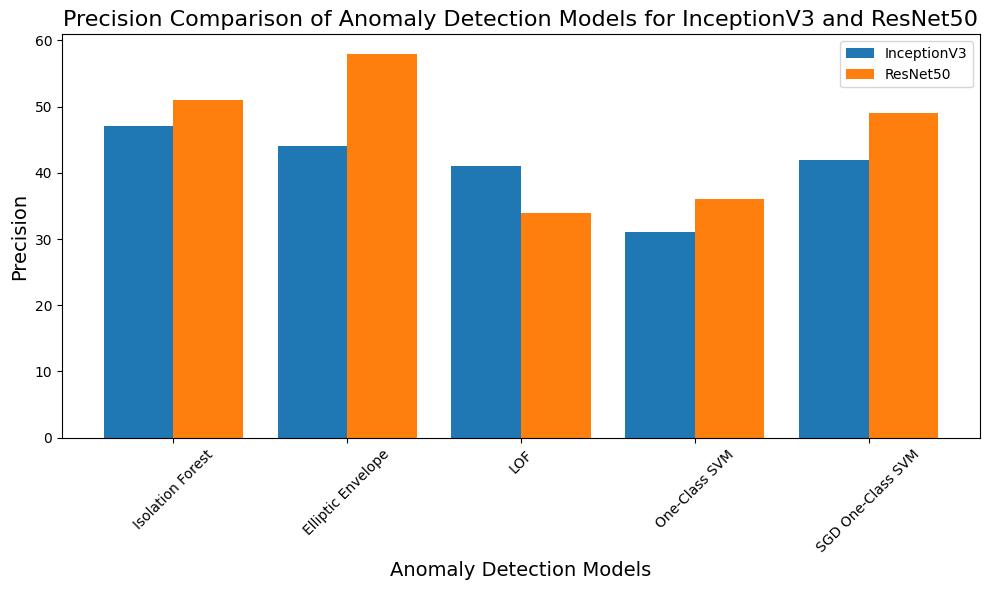

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# Define precision scores for InceptionV3 and ResNet50 quantifiers
precision_inceptionv3 = [47, 44,
                         41, 31,
                         42]
precision_resnet50 = [51, 58,
                      34, 36,
                      49]

# Define models
models = ['Isolation Forest', 'Elliptic Envelope', 'LOF', 'One-Class SVM', 'SGD One-Class SVM']
num_models = len(models)

# Plotting the precision scores for InceptionV3 quantifier
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_models), precision_inceptionv3, width=0.4, align='center', label='InceptionV3')

# Plotting the precision scores for ResNet50 quantifier
plt.bar(np.arange(num_models) + 0.4, precision_resnet50, width=0.4, align='center', label='ResNet50')

# Adding labels and title
plt.xlabel('Anomaly Detection Models', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision Comparison of Anomaly Detection Models for InceptionV3 and ResNet50', fontsize=16)
plt.xticks(np.arange(num_models) + 0.2, models, rotation=45)
plt.legend()
plt.tight_layout()

# Show plot
plt.show()


In [81]:
from sklearn.metrics import confusion_matrix

# Train the Elliptic Envelope model
print("[INFO] Training the Elliptic Envelope model...")
elliptic_model_resnet = EllipticEnvelope(contamination=0.1)
elliptic_model_resnet.fit(X_train)

# Make predictions
print("[INFO] Making predictions...")
y_pred_train = elliptic_model_resnet.predict(X_train)
y_pred_test = elliptic_model_resnet.predict(X_test)

# Convert predictions to binary (1 for anomalies, -1 for normal instances)
y_pred_train_binary = np.where(y_pred_train == 1, -1, 1)
y_pred_test_binary = np.where(y_pred_test == 1, -1, 1)

# Compute confusion matrix for test data
conf_matrix_test = confusion_matrix(y_test, y_pred_test_binary)

# Print confusion matrix
print("Confusion Matrix for Test Data:")
print(conf_matrix_test)

[INFO] Training the Elliptic Envelope model...


c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\covariance\_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\covariance\_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-43364.167560651192616 > -43374.554394260558183). You may want to try with a higher value of support_fraction (current value: 0.656).
  warnings.warn(
c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\covariance\_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-43207.666901725388016 > -43216.687983539515699). You may want to try with a higher value of support_fraction (current value: 0.656).
  warnings.warn(
c:\Users\Ananya Doshi\AppData\

[INFO] Making predictions...
Confusion Matrix for Test Data:
[[ 0  0  0]
 [12  0  0]
 [35  0 25]]


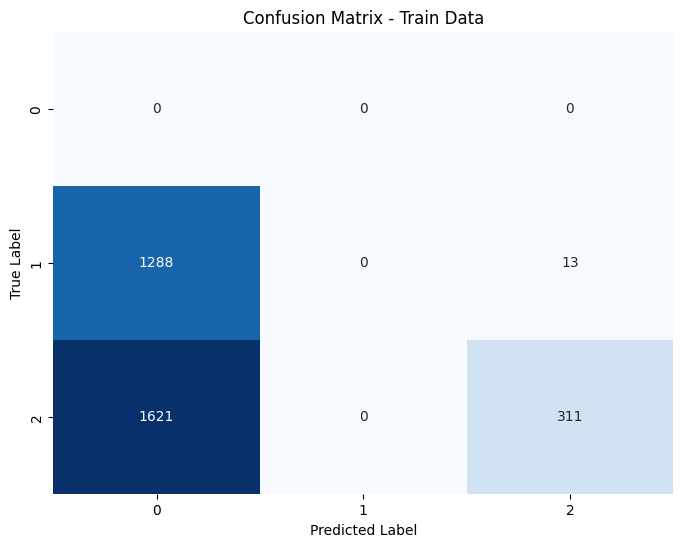

In [84]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

# Compute confusion matrix for test data
conf_matrix_train = confusion_matrix(y_train, y_pred_train_binary)

import seaborn as sns

# Plot confusion matrix for train data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Train Data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Next, we train the model with a simple .fit() after loading in the dataset and initializing the model. We then write it into a .model file.

After downloading the model, we test out the model on one of the images, which is the 16th test image.

In [54]:
import pickle
import cv2
import os
import matplotlib.pyplot as plt

[INFO] loading anomaly detection model...


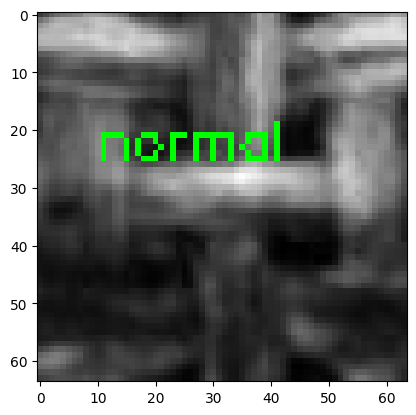

In [55]:

# construct the argument parser and parse the arguments
args = {"model":"anomaly_detector.model", "image": "working/test/damaged/"+os.listdir("working/test/damaged/")[15]}
# load the anomaly detection model
print("[INFO] loading anomaly detection model...")
isolation_model = pickle.loads(open(args["model"], "rb").read())


# load the input image, convert it to the HSV color space, and
# quantify the image in the *same manner* as we did during training
image = cv2.imread(args["image"])
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
features = quantify_image(hsv)

# use the anomaly detector model and extracted features to determine
# if the 16th example image is an anomaly or not
preds = isolation_model.predict([features])[0]
label = "anomaly" if preds == -1 else "normal"
color = (0, 0, 255) if preds == -1 else (0, 255, 0)

# draw the predicted label text on the original image
cv2.putText(image, label, (10,  25), cv2.FONT_HERSHEY_SIMPLEX,
	0.3, color, 1)

# display the image
plt.imshow(image)

Finally, we test this model's precision, recall, and f1 scores on 500 damaged and 500 good images from the test set.

In [56]:
true_positive = 0
false_positive = 0
false_negative = 0
for i in range(500):
    def_image = cv2.imread("working/test/damaged/"+os.listdir("working/test/damaged/")[i])
    def_hsv = cv2.cvtColor(def_image, cv2.COLOR_BGR2HSV)
    def_features = quantify_image(def_hsv)
    def_preds = isolation_model.predict([def_features])[0]
    def_label = "anomaly" if def_preds == -1 else "normal"
    if def_label == "anomaly":
        true_positive += 1
    else:
        false_negative += 1
        
    norm_image = cv2.imread("working/test/good/"+os.listdir("working/test/good/")[i])
    norm_hsv = cv2.cvtColor(norm_image, cv2.COLOR_BGR2HSV)
    norm_features = quantify_image(norm_hsv)
    norm_preds = isolation_model.predict([norm_features])[0]
    norm_label = "anomaly" if norm_preds == -1 else "normal"
    if norm_label == "anomaly": false_positive += 1
        
precision = true_positive/ (true_positive + false_positive)
recall = true_positive/ (true_positive + false_negative)
f1 = 2 * ((precision*recall)/(precision+recall))

print(f"Precision: {precision}\nRecall: {recall}\nf1: {f1}")

Precision: 0.5979381443298969
Recall: 0.116
f1: 0.19430485762144054


Testing with Other Anomaly Detectors
Now, we will find the precision and recall on the test set using some other outlier detection models: namely, the Local Outlier Factor (LOF) algorithm, Gaussian Distributions (EllipticEnvelope), one-class SVM, and SGD one class SVM (stochastic gradient descent)

We will start out with Local Outlier Factor:

In [58]:
#LOCAL OUTLIER FACTOR INCEPTION V3
from sklearn.neighbors import LocalOutlierFactor
# LOF is used for outlier identification
# compares density at each data point by comparing it with its k nearest neighbours
# then it also determines distance to its k nearest neighbour
# Data points with high LOF scores are considered outliers

# contamination and novelty are hyperparameters
# contamination is used to indicate proportion of abnormalities
# novelty means that image is trained on images without outliers and will predict unseen data now
args = {"dataset": "working/train/good", "model": "anomaly_detector_LOF_INCEPTION_V3.model"}
LOF_model = LocalOutlierFactor(contamination=0.1, novelty=True)
LOF_model.fit(data)

true_positive = 0
false_positive = 0
false_negative = 0
for i in range(500):
    def_image = cv2.imread("working/test/damaged/"+os.listdir("working/test/damaged/")[i])
    def_hsv = cv2.cvtColor(def_image, cv2.COLOR_BGR2HSV)
    def_features = quantify_image(def_hsv)
    def_preds = LOF_model.predict([def_features])[0]
    def_label = "anomaly" if def_preds == -1 else "normal"
    if def_label == "anomaly":
        true_positive += 1
    else:
        false_negative += 1
        
    norm_image = cv2.imread("working/test/good/"+os.listdir("working/test/good/")[i])
    norm_hsv = cv2.cvtColor(norm_image, cv2.COLOR_BGR2HSV)
    norm_features = quantify_image(norm_hsv)
    norm_preds = LOF_model.predict([norm_features])[0]
    norm_label = "anomaly" if norm_preds == -1 else "normal"
    if norm_label == "anomaly": false_positive += 1

# serialize the anomaly detection model to disk using pickle
f = open(args["model"], "wb")
f.write(pickle.dumps(LOF_model))
f.close()

precision = true_positive/ (true_positive + false_positive)
recall = true_positive/ (true_positive + false_negative)
f1 = 2 * ((precision*recall)/(precision+recall))

print(f"LOF Precision: {precision}\nLOF Recall: {recall}\nLOF f1: {f1}")

LOF Precision: 0.632258064516129
LOF Recall: 0.196
LOF f1: 0.29923664122137406


Next, we will try out outlier detection with a gaussian distribution using the Elliptic Envelope algorithm:

In [59]:
#ELLIPTIC ENVELOPE INCEPTION V3
from sklearn.covariance import EllipticEnvelope
import warnings
warnings.filterwarnings('ignore')

# This model assumes that mojority of data points follow a normal distribution
# mean and covariance is calculated to construct an alliptic envelope
# distance from each data point to center of distribution calculated
# points lying above given threshold are outliers
args = {"dataset": "working/train/good", "model": "anomaly_detector_ELLEPTIC_ENVELOPE_INCEPTION_V3.model"}
# The support_fraction parameter represents the proportion of data points to be included in the support of the robust estimator. 
Gauss_model = EllipticEnvelope(contamination=0.1, support_fraction=0.9, random_state=42)
Gauss_model.fit(data)

true_positive = 0
false_positive = 0
false_negative = 0
for i in range(500):
    def_image = cv2.imread("working/test/damaged/"+os.listdir("working/test/damaged/")[i])
    def_hsv = cv2.cvtColor(def_image, cv2.COLOR_BGR2HSV)
    def_features = quantify_image(def_hsv)
    def_preds = Gauss_model.predict([def_features])[0]
    def_label = "anomaly" if def_preds == -1 else "normal"
    if def_label == "anomaly":
        true_positive += 1
    else:
        false_negative += 1
        
    norm_image = cv2.imread("working/test/good/"+os.listdir("working/test/good/")[i])
    norm_hsv = cv2.cvtColor(norm_image, cv2.COLOR_BGR2HSV)
    norm_features = quantify_image(norm_hsv)
    norm_preds = Gauss_model.predict([norm_features])[0]
    norm_label = "anomaly" if norm_preds == -1 else "normal"
    if norm_label == "anomaly": false_positive += 1

# serialize the anomaly detection model to disk using pickle
f = open(args["model"], "wb")
f.write(pickle.dumps(Gauss_model))
f.close()

precision = true_positive/ (true_positive + false_positive)
recall = true_positive/ (true_positive + false_negative)
f1 = 2 * ((precision*recall)/(precision+recall))

print(f"Gauss Precision: {precision}\nGauss Recall: {recall}\nGauss f1: {f1}")

Gauss Precision: 0.6355140186915887
Gauss Recall: 0.136
Gauss f1: 0.2240527182866557


Now, we will try the one-class SVM:

In [60]:
from sklearn.svm import OneClassSVM

args = {"dataset": "working/train/good", "model": "anomaly_detector_SVM_INCEPTION_V3.model"}
# used for outlier and novelty detection, meaning trained on good images and prediction on unseen data(classifies any anomoly to damaged)
SVM_model = OneClassSVM()
SVM_model.fit(data)

true_positive = 0
false_positive = 0
false_negative = 0
for i in range(500):
    def_image = cv2.imread("working/test/damaged/"+os.listdir("working/test/damaged/")[i])
    def_hsv = cv2.cvtColor(def_image, cv2.COLOR_BGR2HSV)
    def_features = quantify_image(def_hsv)
    def_preds = SVM_model.predict([def_features])[0]
    def_label = "anomaly" if def_preds == -1 else "normal"
    if def_label == "anomaly":
        true_positive += 1
    else:
        false_negative += 1
        
    norm_image = cv2.imread("working/test/good/"+os.listdir("working/test/good/")[i])
    norm_hsv = cv2.cvtColor(norm_image, cv2.COLOR_BGR2HSV)
    norm_features = quantify_image(norm_hsv)
    norm_preds = SVM_model.predict([norm_features])[0]
    norm_label = "anomaly" if norm_preds == -1 else "normal"
    if norm_label == "anomaly": false_positive += 1

f = open(args["model"], "wb")
f.write(pickle.dumps(SVM_model))
f.close()


precision = true_positive/ (true_positive + false_positive)
recall = true_positive/ (true_positive + false_negative)
f1 = 2 * ((precision*recall)/(precision+recall))

print(f"SVM Precision: {precision}\nSVM Recall: {recall}\nSVM f1: {f1}")

SVM Precision: 0.4878048780487805
SVM Recall: 0.6
SVM f1: 0.538116591928251


Finally, we will try one class SVM with Stochastic Gradient Descent (SGD)

In [61]:
from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM

# SGD involves iteratively updating the model parameters based on the gradient of the loss function calculated on a subset of the training data (a mini-batch). This allows for more scalable and efficient training, especially on large datasets.
args = {"dataset": "working/train/good", "model": "anomaly_detector_SGD_SVM_INCEPTION_V3.model"}
SGD_SVM_model = make_pipeline(
    Nystroem(random_state=42),
    SGDOneClassSVM(shuffle=True, random_state=42)
)
SGD_SVM_model.fit(data)

true_positive = 0
false_positive = 0
false_negative = 0
for i in range(500):
    def_image = cv2.imread("working/test/damaged/"+os.listdir("working/test/damaged/")[i])
    def_hsv = cv2.cvtColor(def_image, cv2.COLOR_BGR2HSV)
    def_features = quantify_image(def_hsv)
    def_preds = SGD_SVM_model.predict([def_features])[0]
    def_label = "anomaly" if def_preds == -1 else "normal"
    if def_label == "anomaly":
        true_positive += 1
    else:
        false_negative += 1
        
    norm_image = cv2.imread("working/test/good/"+os.listdir("working/test/good/")[i])
    norm_hsv = cv2.cvtColor(norm_image, cv2.COLOR_BGR2HSV)
    norm_features = quantify_image(norm_hsv)
    norm_preds = SGD_SVM_model.predict([norm_features])[0]
    norm_label = "anomaly" if norm_preds == -1 else "normal"
    if norm_label == "anomaly": false_positive += 1

f = open(args["model"], "wb")
f.write(pickle.dumps(SGD_SVM_model))
f.close()

precision = true_positive/ (true_positive + false_positive)
recall = true_positive/ (true_positive + false_negative)
f1 = 2 * ((precision*recall)/(precision+recall))

print(f"SGD SVM Precision: {precision}\nSGD SVM Recall: {recall}\nSGD SVM f1: {f1}")

SGD SVM Precision: 0.5
SGD SVM Recall: 1.0
SGD SVM f1: 0.6666666666666666


From these f1 score results, one can see that the SGD SVM works best, followed by normal SVM, Local Outlier Factor, Elliptic Envelope, and the worst being the isolation forest.

Trying IsolationForest with ResNet Quantifier
Previously we used an InceptionNet V3 model to quantify images. Now, we will use a ResNet 101 model for this and compare their performances:

In [10]:
# import the necessary packages
from imutils import paths
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet101
import random
from typing import Tuple

In [11]:
encoder_model = ResNet101(include_top=True, weights='imagenet')

def quantify_image(image, model=encoder_model):
	image_np = cv2.copyMakeBorder(image, 80, 80, 80, 80, cv2.BORDER_CONSTANT)
	image_np = image_np.reshape((1,224,224,3))
	encoding = model(image_np)
	return encoding.numpy().reshape((1000))

def load_dataset(datasetPath, bins):
	# grab the paths to all images in our dataset directory, then
	# initialize our lists of images (only a random 5000)
	imagePaths = list(paths.list_images(datasetPath))
	imagePaths = random.choices(imagePaths, k=5000)
	data = []

	# loop over the image paths
	for imagePath in imagePaths:
		# load the image and convert it to the HSV color space
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

		# quantify the image and update the data list
		features = quantify_image(image)
		data.append(features)

	# return our data list as a NumPy array
	return np.array(data)

In [64]:
# USAGE
# python train_anomaly_detector.py --dataset forest --model anomaly_detector.model

# import the necessary packages
import pickle
from sklearn.ensemble import IsolationForest

# construct the argument parser and parse the arguments
args = {"dataset": "working/train/good", "model": "anomaly_detector_ISOLATION_resnet.model"}

# load and quantify our image dataset
print("[INFO] preparing dataset...")
data = load_dataset(args["dataset"], bins=(3, 3, 3))

# train the anomaly detection model
print("[INFO] fitting anomaly detection model...")
isolation_model_resnet = IsolationForest(n_estimators=100, contamination=0.1,         # Contam originally 0.01, represents threshold
	random_state=42)
isolation_model_resnet.fit(data)

# serialize the anomaly detection model to disk
f = open(args["model"], "wb")
f.write(pickle.dumps(isolation_model_resnet))
f.close()

[INFO] preparing dataset...
[INFO] fitting anomaly detection model...


[INFO] loading anomaly detection model...


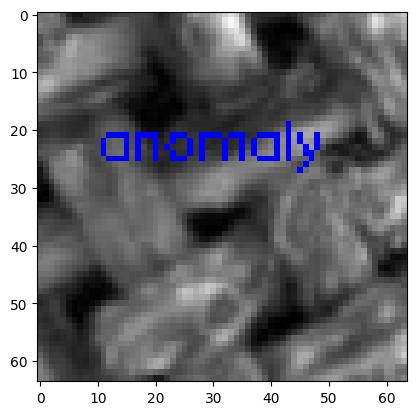

In [12]:
# USAGE
# python test_anomaly_detector.py --model anomaly_detector.model --image examples/highway_a836030.jpg

# import the necessary packages
import pickle
import cv2
import os
import matplotlib.pyplot as plt

# construct the argument parser and parse the arguments
args = {"model":"anomaly_detector_ISOLATION_resnet.model", "image": "working/test/damaged/"+os.listdir("working/test/damaged/")[0]}
# load the anomaly detection model
print("[INFO] loading anomaly detection model...")
isolation_model_resnet = pickle.loads(open(args["model"], "rb").read())

# load the input image, convert it to the HSV color space, and
# quantify the image in the *same manner* as we did during training
image = cv2.imread(args["image"])
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
features = quantify_image(hsv)

# use the anomaly detector model and extracted features to determine
# if the example image is an anomaly or not
preds = isolation_model_resnet.predict([features])[0]
label = "anomaly" if preds == -1 else "normal"
color = (0, 0, 255) if preds == -1 else (0, 255, 0)

# draw the predicted label text on the original image
cv2.putText(image, label, (10,  25), cv2.FONT_HERSHEY_SIMPLEX,
	0.3, color, 1)

# display the image
plt.imshow(image)

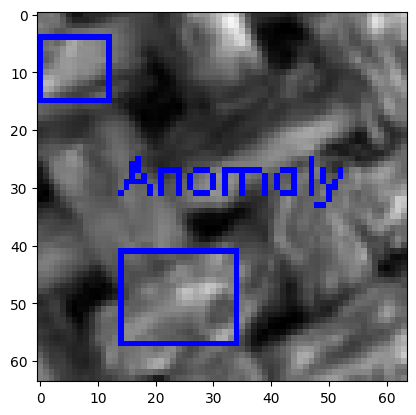

In [13]:
import cv2
import numpy as np

def find_anomaly_location(image, preds, min_contour_area=50, box_thickness=1):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale image to create a binary mask
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on minimum area
    large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

    # Draw bounding box around each contour if it corresponds to an anomaly
    for contour in large_contours:
        x, y, w, h = cv2.boundingRect(contour)
        if preds == -1:
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), box_thickness)  # Red box for anomalies
            cv2.putText(image, "Anomaly", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)
        else:
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), box_thickness)  # Green box for normal
            cv2.putText(image, "Normal", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)

    return image

# Use this function after the existing code to visualize the anomaly location
image = cv2.imread(args["image"])
image_with_box = find_anomaly_location(image, preds)

# Display the image with the anomaly location
plt.imshow(image_with_box)
plt.show()

In [14]:
#BEST
true_positive = 0
false_positive = 0
false_negative = 0
for i in range(500):
    def_image = cv2.imread("working/test/damaged/"+os.listdir("working/test/damaged/")[i])
    def_hsv = cv2.cvtColor(def_image, cv2.COLOR_BGR2HSV)
    def_features = quantify_image(def_hsv)
    def_preds = isolation_model_resnet.predict([def_features])[0]
    def_label = "anomaly" if def_preds == -1 else "normal"
    if def_label == "anomaly":
        true_positive += 1
    else:
        false_negative += 1
        
    norm_image = cv2.imread("working/test/good/"+os.listdir("working/test/good/")[i])
    norm_hsv = cv2.cvtColor(norm_image, cv2.COLOR_BGR2HSV)
    norm_features = quantify_image(norm_hsv)
    norm_preds = isolation_model_resnet.predict([norm_features])[0]
    norm_label = "anomaly" if norm_preds == -1 else "normal"
    if norm_label == "anomaly": false_positive += 1
        
precision = true_positive/ (true_positive + false_positive)
recall = true_positive/ (true_positive + false_negative)
f1 = 2 * ((precision*recall)/(precision+recall))

print(f"Precision: {precision}\nRecall: {recall}\nf1: {f1}")

Precision: 0.8042553191489362
Recall: 0.378
f1: 0.5142857142857142


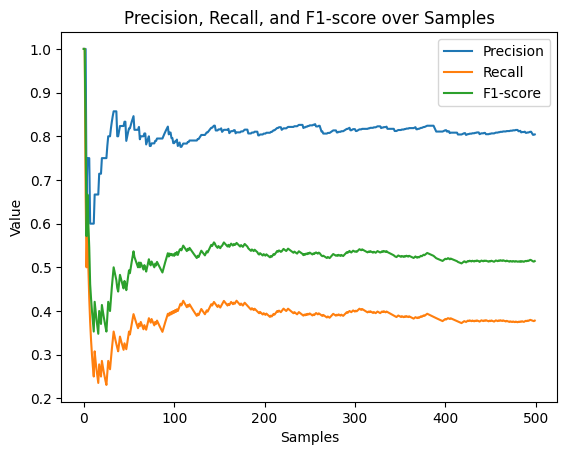

In [15]:
import matplotlib.pyplot as plt

# Initialize lists to store values
precisions = []
recalls = []
f1_scores = []

# Calculate precision, recall, and F1-score
true_positive = 0
false_positive = 0
false_negative = 0
for i in range(500):
    def_image = cv2.imread("working/test/damaged/"+os.listdir("working/test/damaged/")[i])
    def_hsv = cv2.cvtColor(def_image, cv2.COLOR_BGR2HSV)
    def_features = quantify_image(def_hsv)
    def_preds = isolation_model_resnet.predict([def_features])[0]
    def_label = "anomaly" if def_preds == -1 else "normal"
    if def_label == "anomaly":
        true_positive += 1
    else:
        false_negative += 1
        
    norm_image = cv2.imread("working/test/good/"+os.listdir("working/test/good/")[i])
    norm_hsv = cv2.cvtColor(norm_image, cv2.COLOR_BGR2HSV)
    norm_features = quantify_image(norm_hsv)
    norm_preds = isolation_model_resnet.predict([norm_features])[0]
    norm_label = "anomaly" if norm_preds == -1 else "normal"
    if norm_label == "anomaly": false_positive += 1
        
    precision = true_positive/ (true_positive + false_positive)
    recall = true_positive/ (true_positive + false_negative)
    f1 = 2 * ((precision*recall)/(precision+recall))
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Plot the graph
plt.plot(precisions, label='Precision')
plt.plot(recalls, label='Recall')
plt.plot(f1_scores, label='F1-score')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.title('Precision, Recall, and F1-score over Samples')
plt.legend()
plt.show()


As you can see, for the isolation forest, using ResNet101 works better than InceptionNetV3. Let's try SGD SVM:

In [69]:
from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM

args = {"dataset": "working/train/good", "model": "anomaly_detector_SGD_SVM_RESNET.model"}
SGD_SVM_model_resnet = make_pipeline(
    Nystroem(random_state=42),
    SGDOneClassSVM(shuffle=True, random_state=42)
)
SGD_SVM_model_resnet.fit(data)

true_positive = 0
false_positive = 0
false_negative = 0
for i in range(500):
    def_image = cv2.imread("working/test/damaged/"+os.listdir("working/test/damaged/")[i])
    def_hsv = cv2.cvtColor(def_image, cv2.COLOR_BGR2HSV)
    def_features = quantify_image(def_hsv)
    def_preds = SGD_SVM_model_resnet.predict([def_features])[0]
    def_label = "anomaly" if def_preds == -1 else "normal"
    if def_label == "anomaly":
        true_positive += 1
    else:
        false_negative += 1
        
    norm_image = cv2.imread("working/test/good/"+os.listdir("working/test/good/")[i])
    norm_hsv = cv2.cvtColor(norm_image, cv2.COLOR_BGR2HSV)
    norm_features = quantify_image(norm_hsv)
    norm_preds = SGD_SVM_model_resnet.predict([norm_features])[0]
    norm_label = "anomaly" if norm_preds == -1 else "normal"
    if norm_label == "anomaly": false_positive += 1

f = open(args["model"], "wb")
f.write(pickle.dumps(SGD_SVM_model_resnet))
f.close()

precision = true_positive/ (true_positive + false_positive)
recall = true_positive/ (true_positive + false_negative)
f1 = 2 * ((precision*recall)/(precision+recall))

print(f"SGD SVM Precision: {precision}\nSGD SVM Recall: {recall}\nSGD SVM f1: {f1}")

SGD SVM Precision: 0.501269035532995
SGD SVM Recall: 0.79
SGD SVM f1: 0.6133540372670808


In [70]:
# USAGE
# python train_anomaly_detector.py --dataset forest --model anomaly_detector.model

# import the necessary packages
import pickle
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

args = {"dataset": "working/train/good", "model": "anomaly_detector_SVM_RESNET.model"}
# used for outlier and novelty detection, meaning trained on good images and prediction on unseen data(classifies any anomoly to damaged)
SVM_model_resnet = OneClassSVM()
SVM_model_resnet.fit(data)

# load and quantify our image dataset
print("[INFO] preparing dataset...")
data = load_dataset(args["dataset"], bins=(3, 3, 3))

# train the anomaly detection model
print("[INFO] fitting anomaly detection model...")
SVM_model_resnet = OneClassSVM(n_estimators=100, contamination=0.1,         # Contam originally 0.01, represents threshold
	random_state=42)
SVM_model_resnet.fit(data)

# serialize the anomaly detection model to disk
f = open(args["model"], "wb")
f.write(pickle.dumps(SVM_model_resnet))
f.close()

[INFO] preparing dataset...
[INFO] fitting anomaly detection model...


TypeError: OneClassSVM.__init__() got an unexpected keyword argument 'n_estimators'

In [80]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
import os
args = {"dataset": "working/train/good", "model": "anomaly_detector.model"}
data = load_dataset(args["dataset"], bins=(3, 3, 3))
# Load trained models
isolation_model = pickle.loads(open("anomaly_detector.model", "rb").read())
LOF_model = pickle.loads(open("anomaly_detector_LOF_INCEPTION_V3.model", "rb").read())
Gauss_model = pickle.loads(open("anomaly_detector_ELLEPTIC_ENVELOPE_INCEPTION_V3.model", "rb").read())
SVM_model = pickle.loads(open("anomaly_detector_SVM_INCEPTION_V3.model", "rb").read())
SGD_SVM_model = pickle.loads(open("anomaly_detector_SGD_SVM_INCEPTION_V3.model", "rb").read())

# train_data_good = load_dataset("working/train/good", bins=(3, 3, 3))
# train_data_damaged = load_dataset("working/train/damaged", bins=(3, 3, 3))
# train_data = np.vstack((train_data_good, train_data_damaged)) 
# train_labels = np.concatenate([np.zeros(len(train_data_good)), np.ones(len(train_data_damaged))])


In [81]:
# from sklearn.ensemble import VotingClassifier
# from sklearn.metrics import accuracy_score

# # Load trained models
# isolation_model = pickle.loads(open("anomaly_detector.model", "rb").read())
# LOF_model=pickle.loads(open("anomaly_detector_LOF_INCEPTION_V3.model","rb").read())
# Gauss_model=pickle.loads(open("anomaly_detector_ELLEPTIC_ENVELOPE_INCEPTION_V3.model","rb").read())
# SVM_model=pickle.loads(open("anomaly_detector_SVM_INCEPTION_V3.model","rb").read())
# SGD_SVM_model=pickle.loads(open("anomaly_detector_SGD_SVM_INCEPTION_V3.model","rb").read())

# # LOF_model = LocalOutlierFactor(contamination=0.1, novelty=True)
# # Gauss_model = EllipticEnvelope(contamination=0.1, support_fraction=0.9, random_state=42)
# # SVM_model = OneClassSVM()
# # SGD_SVM_model = make_pipeline(Nystroem(random_state=42), SGDOneClassSVM(shuffle=True, random_state=42))

# # Create an ensemble of models
# ensemble_model = VotingClassifier(
#     estimators=[
#         ('IsolationForest', isolation_model),
#         ('LOF', LOF_model),
#         ('Gauss', Gauss_model),
#         ('SVM', SVM_model),
#         ('SGD_SVM', SGD_SVM_model)
#     ],
#     voting='hard'  # 'hard' for majority voting, 'soft' for weighted voting based on confidence
# )

# # Load test data
# test_data = load_dataset("working/test/good", bins=(3, 3, 3))

# # Make predictions using the ensemble model
# ensemble_preds = ensemble_model.predict(test_data)

# # Evaluate the ensemble model
# accuracy = accuracy_score(ensemble_preds, [0] * len(ensemble_preds))  # Assuming normal class is labeled as 0
# print(f"Ensemble Model Accuracy: {accuracy}")
# *********************************************************************************

# Assuming data is your feature matrix
dummy_labels = np.zeros(len(data))

# Create an ensemble of models
ensemble_model = VotingClassifier(
    estimators=[
        ('IsolationForest', isolation_model),
        ('LOF', LOF_model),
        ('Gauss', Gauss_model),
        ('SVM', SVM_model),
        ('SGD_SVM', SGD_SVM_model)
    ],
    voting='hard'  # 'hard' for majority voting
)
print("fitting started")
ensemble_model.fit(data,dummy_labels)
print("fitting ended")


fitting started


ValueError: The estimator IsolationForest should be a classifier.

In [78]:
from sklearn.metrics import accuracy_score
# Load test data
test_data_good = load_dataset("working/test/good", bins=(3, 3, 3))
test_data_damaged = load_dataset("working/test/damaged", bins=(3, 3, 3))
test_data = np.vstack((test_data_good, test_data_damaged))
test_labels = np.concatenate([np.zeros(len(test_data_good)), np.ones(len(test_data_damaged))])

print("prediction started")
# Make predictions using each model
isolation_preds = isolation_model.predict(test_data)
LOF_preds = LOF_model.predict(test_data)
Gauss_preds = Gauss_model.predict(test_data)
SVM_preds = SVM_model.predict(test_data)
SGD_SVM_preds = SGD_SVM_model.predict(test_data)
ensemble_preds = ensemble_model.predict(test_data)

# Combine predictions using majority voting
# ensemble_preds = np.round((isolation_preds + LOF_preds + Gauss_preds + SVM_preds + SGD_SVM_preds) / 5)
# accuracy = accuracy_score(ensemble_preds, np.ones_like(ensemble_preds))  # Assuming all predictions are anomalies
# print(f"Ensemble Model Accuracy: {accuracy}")
# Evaluate each model
models = [
    ('IsolationForest', isolation_preds),
    ('LOF', LOF_preds),
    ('Gauss', Gauss_preds),
    ('SVM', SVM_preds),
    ('SGD_SVM', SGD_SVM_preds),
    ('Ensemble', ensemble_preds)
]
print("prediction ended")

for model_name, preds in models:
    precision = precision_score(test_labels, preds)
    recall = recall_score(test_labels, preds)
    f1 = f1_score(test_labels, preds)
    print(f"{model_name} - Precision: {precision}, Recall: {recall}, F1 Score: {f1}")


prediction started
Ensemble Model Accuracy: 0.0
